<a href="https://www.kaggle.com/code/riturajpradhan/resnet18-on-rafdb?scriptVersionId=198460587" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
import json

from PIL import Image, ImageEnhance, ImageOps, ImageDraw
from tqdm.notebook import tqdm
import gc
import numpy as np
import pandas as pd
import time
import copy
from collections import Counter
import ast
import random
import argparse
import math
import random

# from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast
from torch.utils.tensorboard import SummaryWriter
import torch.nn.init as init

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

from sklearn.model_selection import KFold

from timm.scheduler.scheduler import Scheduler
from timm.loss import LabelSmoothingCrossEntropy
import timm

from torchvision import transforms
import torchvision

import cv2
# import insightface
# from insightface.app import FaceAnalysis
# from insightface.data import get_image as ins_get_image
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '/kaggle/working/CFERNet')
from auto_augment import AutoAugment

# Trying to import resnet18 model

In [2]:
def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU()
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, end2end=True):
        self.inplanes = 64
        self.end2end = end2end
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512,num_classes)#2048 fr 50
        #self.classifier =  nn.Linear(512,num_classes)#2048 fr 50
        
        #self.threedmm_layer = threeDMM_model(alfa,threed_model_data)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
       
        bs = x.size(0)
        f = x

        f = self.conv1(f)
        f = self.bn1(f)
        f = self.relu(f)
        f = self.maxpool(f)
        
        f = self.layer1(f)
        #print('layer1: ',f.size())
        f = self.layer2(f)
        #print('layer2: ',f.size())
       
        f = self.layer3(f)
        feature = f.view(bs, -1)
        #print('layer4: ',f.size())
        f = self.layer4(f)
        #print('layer4: ',f.size())
        f = self.avgpool(f)
        
        f = f.squeeze(3).squeeze(2)
        pred = self.fc(f)
        #pred = self.classifier(f)
        #print('fc: ',f.size())
        #return f#pred
        return  pred

def resnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet18']))
        print('Loading pretrained imagenet model')
        
    return model

In [3]:
landmarks_cache = {}

# Open the file and read all lines first to calculate total length for progress bar
with open('/kaggle/input/ferplus/FERPlus_Train_kps.txt', 'r') as file:
    lines = file.readlines()

# Iterate over lines with progress bar
for line in tqdm(lines, desc="Processing landmarks", unit="lines"):
    # Split at the first occurrence of the colon
    file_name, coordinates = line.split(":", 1)

    # Remove whitespace around the file name
    file_name = file_name.strip()

    # Convert the string representation of the list of tuples to an actual list of tuples
    coordinates = ast.literal_eval(coordinates.strip())

    # Add to the dictionary
    landmarks_cache[file_name] = coordinates

Processing landmarks:   0%|          | 0/30996 [00:00<?, ?lines/s]

# RafDB DATA Loader

In [73]:
def PIL_loader(path):
    try:
        with open(path, 'rb') as f:
            return Image.open(f).convert('RGB')
    except IOError:
        print('Cannot load image ' + path)
        
def change_emotion_label_same_as_affectnet(emo_to_return):
        """
        Parse labels to make them compatible with AffectNet.  
        #https://github.com/siqueira-hc/Efficient-Facial-Feature-Learning-with-Wide-Ensemble-based-Convolutional-Neural-Networks/blob/master/model/utils/udata.py
        """

        if emo_to_return == 0:
            emo_to_return = 3
        elif emo_to_return == 1:
            emo_to_return = 4
        elif emo_to_return == 2:
            emo_to_return = 5
        elif emo_to_return == 3:
            emo_to_return = 1
        elif emo_to_return == 4:
            emo_to_return = 2
        elif emo_to_return == 5:
            emo_to_return = 6
        elif emo_to_return == 6:
            emo_to_return = 0

        return emo_to_return

def default_reader(fileList):
    #print(fileList)
    counter_loaded_images_per_label = [0 for _ in range(7)]

    num_per_cls_dict = dict()
    for i in range(0, 7):
        num_per_cls_dict[i] = 0

    imgList = []
    if fileList.find('occlusion_list.txt') > -1:
        fp = open(fileList,'r')
        for names in fp.readlines():
            image_path, target, _  = names.split(' ')  #Eg. test_0025_aligned 3 3 #name, Ist target, 2nd target
            image_path = image_path.strip()+'.jpg'
            target = int(target) 
            target = change_emotion_label_same_as_affectnet(target)
            num_per_cls_dict[target] = num_per_cls_dict[target] + 1 
            imgList.append((image_path, target))           
        return imgList ,    num_per_cls_dict
             
    elif  fileList.find('pose') > -1:
        fp = open(fileList,'r')
        for names in fp.readlines():
            target, image_path  = names.split('/')  #Eg. for each entry before underscore lable and afterwards name in 1/fer0034656.jpg
            image_path = image_path.strip()
            #print(target,image_path)
            target = int(target) 
            target = change_emotion_label_same_as_affectnet(target)
            num_per_cls_dict[target] = num_per_cls_dict[target] + 1 
            imgList.append((image_path, target))
        return imgList ,    num_per_cls_dict 
    else:#test/train/validation.csv
 
        fp = open(fileList,'r')

        for names in fp.readlines():
            image_path, target  = names.split(' ')  #Eg. for each entry before underscore lable and afterwards name in 1_fer0034656.png 8 0, 2_fer0033878.png 8 0

            name,ext = image_path.strip().split('.')                #imagename is name.jpg  --->  name_algined.jpg

            image_path  = name + '_aligned.' + ext

            target  =  int(target) - 1 #labels are from 1-7

            target = change_emotion_label_same_as_affectnet(target)

            counter_loaded_images_per_label[target] += 1 

            num_per_cls_dict[target] = num_per_cls_dict[target] + 1 

            imgList.append((image_path, int(target)))

        fp.close()

        return imgList, num_per_cls_dict

class ImageList(Dataset):
    def __init__(self, root, fileList,  transform=None, list_reader=default_reader, loader=PIL_loader, step = None):
        self.root = root
        self.cls_num = 7
        self.imgList, self.num_per_cls_dict = list_reader(fileList)
        self.transform = transform
        self.loader = loader
        self.is_save = True
        self.totensor = transforms.ToTensor()
        self.landmark_cache = landmarks_cache
        self.step = step
        
    def draw_squares_on_landmarks(self, img, landmarks, n):
    # Resize the input image to 224x224
        dimg = img.resize((224, 224))

        if n == 0:
            return dimg
        half_n = n // 2
        draw = ImageDraw.Draw(dimg)

        for kp in landmarks:
            # Keypoints are already in the 224x224 scale
            kp_x, kp_y = kp[0], kp[1]

            # Ensure coordinates are integers
            top_left = (int(kp_x - half_n), int(kp_y - half_n))
            bottom_right = (int(kp_x + half_n), int(kp_y + half_n))

            # Draw black rectangle on the keypoint
            draw.rectangle([top_left, bottom_right], fill=(0, 0, 0))  # fill the rectangle with black

        return dimg
    def __getitem__(self, index):
        imgPath, target_expression = self.imgList[index]
#         print(imgPath, target_expression)
        img1 = self.loader(os.path.join(self.root, imgPath))
            
#         if imgPath in self.landmark_cache and self.step:
# #             print('found landmarks:')
#             img2 = self.draw_squares_on_landmarks(img1, self.landmark_cache[imgPath], self.step)
#         else:
#             img2 = img1.copy()
        img2 = img1.copy()


        if random.random() > 0.5:
            img2 = img2.transpose(Image.FLIP_LEFT_RIGHT)
        else:
            img2 = img2
        
        if self.transform is not None:
#             print(f'performing transformations. shape before: {img1.size}')
            img1 = self.transform(img1)
            img2 = self.transform(img2)
#             print(f'new stuff: {type(img1)}, {img1.shape}')
        return img1,img2, target_expression

    def __len__(self):
        return len(self.imgList)

    def get_cls_num_list(self):
        cls_num_list = []
        for i in range(self.cls_num):
            cls_num_list.append(self.num_per_cls_dict[i])
        return cls_num_list

# FERPlus DataLoader

In [4]:
def PIL_loader(path):
    try:
        with open(path, 'rb') as f:
            return Image.open(f).convert('RGB')
    except IOError:
        print('Cannot load image ' + path)


def make_emotion_compatible_to_affectnet(emo_to_return):
        """
        Parse labels to make them compatible with AffectNet.
        :param idx:
        :return:
        """

        if emo_to_return == 2:
            emo_to_return = 3
        elif emo_to_return == 3:
            emo_to_return = 2
        elif emo_to_return == 4:
            emo_to_return = 6
        elif emo_to_return == 6:
            emo_to_return = 4

        return emo_to_return



def default_reader(fileList, mode, num_expression=8):
    imgList = []
    i = 0
    fp = open(fileList,'r')

    for names in fp.readlines():
        image_path, target  = names.split(' ')  #Eg. for each entry before underscore lable and afterwards name in 1_fer0034656.png 8 0, 2_fer0033878.png 8 0

        target  =  int(target) #labels are from 1-7

#             target = make_emotion_compatible_to_affectnet(target)

#         counter_loaded_images_per_label[target] += 1 

#         num_per_cls_dict[target] = num_per_cls_dict[target] + 1 

        imgList.append((image_path, int(target)))

    fp.close()

    return imgList

class ImageList(data.Dataset):
    def __init__(self, root, fileList, transform=None, num_expressions = 8, list_reader=default_reader, loader = PIL_loader, mode = 'majority', step = 0):
        self.root = root
        self.transform = transform
        self.loader = loader
        self.fileList  = fileList
        self.training_mode = mode
        self.landmark_cache = landmarks_cache
        self.num_expression =  num_expressions
        self.step = step

        self.imgList = list_reader(fileList, self.training_mode, self.num_expression)
        self.num_per_cls_dict = self.get_class_wise_count()
#         print('checking class wise list: ', self.num_per_cls_dict)

    def get_class_wise_count(self):
        num_per_cls_dict = dict()
        for i in range(0, self.num_expression):
            num_per_cls_dict[i] = 0

        for _,target in self.imgList:
            target_int = target
            target_int = make_emotion_compatible_to_affectnet(target_int)

            num_per_cls_dict[target_int] = num_per_cls_dict[target_int] + 1 
        return num_per_cls_dict
            
    def _process_target(self, target):
        '''
        Based on https://arxiv.org/abs/1608.01041 the target depend on the training mode.
        Majority or crossentropy: return the probability distribution generated by "_process_data"
        Probability: pick one emotion based on the probability distribtuion.
        Multi-target:
        '''
        if self.training_mode == 'majority' or self.training_mode == 'crossentropy':
            target = np.argmax(target)
            return target
        elif self.training_mode == 'probability':            
            idx = np.random.choice(len(target), p=target)
            return idx
        
    def draw_squares_on_landmarks(self, img, landmarks, n):
    # Resize the input image to 224x224
        dimg = img.resize((224, 224))

        if n == 0:
            return dimg
        half_n = n // 2
        draw = ImageDraw.Draw(dimg)

        for kp in landmarks:
            # Keypoints are already in the 224x224 scale
            kp_x, kp_y = kp[0], kp[1]

            # Ensure coordinates are integers
            top_left = (int(kp_x - half_n), int(kp_y - half_n))
            bottom_right = (int(kp_x + half_n), int(kp_y + half_n))

            # Draw black rectangle on the keypoint
            draw.rectangle([top_left, bottom_right], fill=(0, 0, 0))  # fill the rectangle with black

        return dimg
        
    def __getitem__(self, index):

        imgPath, target_expression = self.imgList[index]
#         print(os.path.join(self.root, imgPath))
        img1 = self.loader(os.path.join(self.root, imgPath + '.png'))
    
#         print(imgPath)
        
        if imgPath + '.png' in self.landmark_cache and self.step and random.random() > 0.5:
#             print('found landmarks:')
            img2 = self.draw_squares_on_landmarks(img1, self.landmark_cache[imgPath + '.png'], self.step)
        else:
            img2 = img1.copy()

#         img2 = img1.copy()

        if random.random() > 0.5:
            img2 = img2.transpose(Image.FLIP_LEFT_RIGHT)
        
        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)


        target_expression = make_emotion_compatible_to_affectnet(target_expression) #converts into emtion category same as that of affectnet

        return img1,img2, target_expression

    def __len__(self):
        return len(self.imgList)

    def get_cls_num_list(self):
        cls_num_list = []
        for i in range(self.num_expression):
            cls_num_list.append(self.num_per_cls_dict[i])
        return cls_num_list

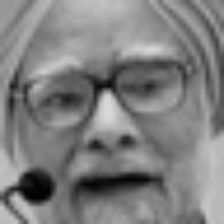

In [7]:
train_transform = transforms.Compose([                      
#         AutoAugment(),
        transforms.Resize((224,224)),            
        transforms.ToTensor(),
    ])

train_dataset = ImageList(root='/kaggle/input/ferplus/FER2013TrainValid/FER2013TrainValid', fileList='/kaggle/input/ferplus/ferplus_trainvalid_list.txt',
                  transform=train_transform, step = 5)
count = 0
for a,b,c in train_dataset:
#     to_pil = transforms.ToPILImage()
#     input1_img = to_pil(b)  # Convert only the first image in the batch to PIL
#     display(input1_img)
    break
to_pil = transforms.ToPILImage()
input1_img = to_pil(a)  # Convert only the first image in the batch to PIL
display(input1_img)  # Display the PIL image

In [8]:
def validate(val_loader, basemodel, criterion, epoch, scheduler, writer= None, run = 0):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    overall_loss = AverageMeter()
    top1 = AverageMeter()
    mode = 'Testing'

    all_preds = []
    all_targets = []
    
    avg_loss = 0
    avg_acc = 0
    count = 0

    # Ensure model is on the correct device
    basemodel.to(device)

    # Switch to evaluate mode
    basemodel.eval()

    end = time.time()

    with torch.no_grad():
        # Use tqdm for the progress bar
        with tqdm(total=len(val_loader), desc=f"Validation Epoch {epoch}", unit="batch") as pbar:
            for i, (input1, input2, target) in enumerate(val_loader):
                # Measure data loading time
                data_time.update(time.time() - end)

                # Move inputs to device
                input1 = input1.to(device)
                target = target.to(device)

                # Compute predictions
                region_preds = basemodel(input1)

                # Compute loss
                loss = criterion(region_preds, target)
                overall_loss.update(loss.item(), input1.size(0))

                # Calculate accuracy
                avg_prec = accuracy(region_preds, target, topk=(1,))
                top1.update(avg_prec[0], input1.size(0))

                # Store predictions and targets for metrics calculation
                preds = torch.argmax(region_preds, dim=1).cpu().numpy()
                all_preds.extend(preds)
                all_targets.extend(target.cpu().numpy())

                # Measure elapsed time
                batch_time.update(time.time() - end)
                end = time.time()

                # Update progress bar
                pbar.set_postfix(
                    batch_time=batch_time.avg,
                    data_time=data_time.avg,
                    overall_loss=overall_loss.avg,
                    Prec1=top1.avg,
                )
                pbar.update(1)

                # Log the metrics
#                 if writer:
                avg_loss += loss.item()
                avg_acc += top1.avg
                count += 1
#                     writer.add_scalar(f'Validation_{run}/Loss', loss.item(), epoch * len(val_loader) + i)
#                     writer.add_scalar(f'Validation_{run}/Accuracy', top1.avg, epoch * len(val_loader) + i)

        # Calculate precision, recall, F1 score
        precision = precision_score(all_targets, all_preds, average='weighted')
        recall = recall_score(all_targets, all_preds, average='weighted')
        f1 = f1_score(all_targets, all_preds, average='weighted')

        # Log precision, recall, and F1 score
        if writer:
            writer.add_scalar(f'Validation_{run}/Precision', precision, epoch)
            writer.add_scalar(f'Validation_{run}/Recall', recall, epoch)
            writer.add_scalar(f'Validation_{run}/F1_Score', f1, epoch)
            writer.add_scalar(f'Validation_{run}/Loss', avg_loss/count, epoch)
            writer.add_scalar(f'Validation_{run}/Accuracy', avg_acc/count, epoch)


        print(f'\n{mode} [{epoch}/{len(val_loader)}]\t'
              f'overall_loss ({overall_loss.avg:.4f})\t'
              f'Prec@1  ({top1.avg:.4f})\t')

        # Step the scheduler
        scheduler.step(overall_loss.avg)

    return top1.avg


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_transform = transforms.Compose([                      
#         AutoAugment(),
        transforms.Resize((224,224)),            
        transforms.ToTensor(),
    ])

valid_transform = transforms.Compose([
        transforms.Resize((224,224)),            
        transforms.ToTensor(),

    ])

train_dataset = ImageList(root='/kaggle/input/ferplus/FER2013TrainValid/FER2013TrainValid', fileList='/kaggle/input/ferplus/ferplus_trainvalid_list.txt',
                  transform=train_transform)
cls_num_list = train_dataset.get_cls_num_list()
# print(cls_num_list)

# Using Reweight training rule because idk what sir used
train_sampler = None
beta = 0.9999                 #0:normal weighting
effective_num = 1.0 - np.power(beta, cls_num_list)
# print(effective_num)
per_cls_weights = (1.0 - beta) / np.array(effective_num)
per_cls_weights = per_cls_weights / np.sum(per_cls_weights) * len(cls_num_list)
per_cls_weights = torch.FloatTensor(per_cls_weights).to(device)

In [10]:
basemodel = resnet18(pretrained= False)
basemodel.fc = nn.Linear(512, 8)
  
# basemodel = torch.nn.DataParallel(basemodel).to(device)
checkpoint = torch.load('/kaggle/input/rafdb-dg/res18_naive.pth_MSceleb')
pretrained_state_dict = checkpoint['state_dict']
new_state_dict = {}
for key in pretrained_state_dict.keys():
    new_key = key.replace('module.', '')  # Remove 'module.' prefix
    new_state_dict[new_key] = pretrained_state_dict[key]
    
model_state_dict = basemodel.state_dict()

for key in new_state_dict:
    if  ((key=='fc.weight')|(key=='fc.bias')|(key == 'feature.weight')|(key == 'feature.bias')):
        pass
    else:
        model_state_dict[key] = new_state_dict[key]

basemodel.load_state_dict(model_state_dict, strict = True)
basemodel = basemodel.to(device)
print('Model loaded from Msceleb pretrained')   
# print('\nNumber of trainable parameters: {}\n'.format(count_parameters(basemodel)))

/tmp/ipykernel_37/627968957.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/kaggle/input/rafdb-dg/res18_naive.pth_MSceleb')


Model loaded from Msceleb pretrained


In [11]:
batch_size = 64

criterion = nn.CrossEntropyLoss(weight=per_cls_weights).to(device)
optimizer = torch.optim.Adamax(basemodel.parameters(), betas=(0.9, 0.999), eps=1e-08, weight_decay=4e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=5, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)    

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=(train_sampler is None), pin_memory=True, sampler=train_sampler)    
    
test_data = ImageList('/kaggle/input/ferplus/FER2013Test/FER2013Test', fileList='/kaggle/input/ferplus/ferplus_test.txt',
              transform=valid_transform)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                     shuffle=False, pin_memory=True)

In [12]:
epoch = 0
prec1 = validate(test_loader, basemodel, criterion,  epoch, scheduler)
print("Epoch: {}   Test Acc: {}".format(epoch, prec1))

Validation Epoch 0:   0%|          | 0/50 [00:00<?, ?batch/s]


Testing [0/50]	overall_loss (2.1089)	Prec@1  (5.0367)	
Epoch: 0   Test Acc: 5.036659240722656


In [13]:
def train(train_loader, basemodel, criterion, optimizer, num_epochs, epoch, writer, run):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    overall_loss = AverageMeter()
    top1 = AverageMeter()
    
#     step = max(0, 5 - epoch // 8)                  # decreasing patch size

    if epoch < 10:
        step = 0
    else:
        step = (epoch - 10) // 8 + 1
        
    print(f'Epoch {epoch}; step = {step}')
    
    
    train_dataset = ImageList(root='/kaggle/input/ferplus/FER2013TrainValid/FER2013TrainValid', fileList='/kaggle/input/ferplus/ferplus_trainvalid_list.txt',
                  transform=train_transform, step = step)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=(train_sampler is None), pin_memory=True, sampler=train_sampler) 
    
    all_preds = []
    all_targets = []

    end = time.time()
    
    flag = True
    
    avg_loss = 0
    avg_acc = 0
    count = 0
    
    # Wrap the train_loader with tqdm for the progress bar
    with tqdm(total=len(train_loader), desc=f"Epoch {epoch}", unit="batch") as pbar:
#         i am swapping names of input1 and input2. now. input1 has augmented data
        for i, (input2, input1, target) in enumerate(train_loader):
            # Measure data loading time
            if flag:
                # Convert the tensor to a PIL image
                to_pil = transforms.ToPILImage()

                # Convert the first image in the batch to PIL images
                input1_img = to_pil(input1[0])
#                 input2_img = to_pil(input2[0])

#                 # Create a new blank image with double the width to hold both images
#                 grid_width = input1_img.width + input2_img.width
#                 grid_height = max(input1_img.height, input2_img.height)

#                 grid_img = Image.new('RGB', (grid_width, grid_height))

#                 # Paste input1_img and input2_img side by side
#                 grid_img.paste(input1_img, (0, 0))  # Paste input1 at (0, 0)
#                 grid_img.paste(input2_img, (input1_img.width, 0))  # Paste input2 next to input1

                # Display the grid image with both images
                display(input1_img)

                flag = False

            data_time.update(time.time() - end)
            
#             if step > 0:
#                 input1 = torch.cat([input1, input2], dim=0)
#                 target = torch.cat([target, target], dim = 0)

            input1 = input1.to(device)
            target = target.to(device)

            # Compute output
            region_preds = basemodel(input1)
            loss = criterion(region_preds, target)
            overall_loss.update(loss.item(), input1.size(0))

            # Calculate accuracy
            avg_prec = accuracy(region_preds, target, topk=(1,))
            top1.update(avg_prec[0], input1.size(0))

            # Store predictions and targets for metrics calculation
            preds = torch.argmax(region_preds, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_targets.extend(target.cpu().numpy())

            # Compute gradient and update
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            # Update the progress bar
            pbar.set_postfix(
                batch_time=batch_time.avg,
                data_time=data_time.avg,
                overall_loss=overall_loss.avg,
                Prec1=top1.avg,
            )
            pbar.update(1)

            # Log the metrics
            avg_loss += loss.item()
            avg_acc += top1.avg
            count += 1
#             writer.add_scalar(f'Train_{run}/Loss', loss.item(), epoch * len(train_loader) + i)
#             writer.add_scalar(f'Train_{run}/Accuracy', top1.avg, epoch * len(train_loader) + i)

    # Calculate precision, recall, F1 score
    precision = precision_score(all_targets, all_preds, average='weighted')
    recall = recall_score(all_targets, all_preds, average='weighted')
    f1 = f1_score(all_targets, all_preds, average='weighted')
    ls = avg_loss/count
    acc = avg_acc/count

    # Log precision, recall, and F1 score
    writer.add_scalar(f'Train_{run}/Precision', precision, epoch)
    writer.add_scalar(f'Train_{run}/Recall', recall, epoch)
    writer.add_scalar(f'Train_{run}/F1_Score', f1, epoch)
    writer.add_scalar(f'Train_{run}/Loss', ls, epoch)
    writer.add_scalar(f'Train_{run}/Accuracy', acc, epoch)
    writer.add_scalar(f'Train_{run}/Step', step, epoch)



    # Log the learning rate
    for param_group in optimizer.param_groups:
        writer.add_scalar(f'Train_{run}/Learning_Rate', param_group['lr'], epoch)

    return top1.avg


# add summaryWriter to log base training
# train for 50 epochs
# implement FiFA and observe changes

In [71]:
os.remove('/kaggle/working/run_7/events.out.tfevents.1727075140.dd049e723a8f.36.5')


Training starting:

Epoch 0; step = 0


Epoch 0:   0%|          | 0/442 [00:00<?, ?batch/s]

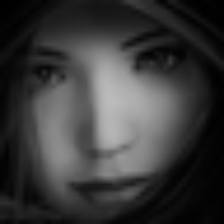

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Epoch 0:   0%|          | 0/50 [00:00<?, ?batch/s]

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Testing [0/50]	overall_loss (2.0577)	Prec@1  (28.3711)	
Epoch: 0   Test Acc: 28.371055603027344

So far best epoch, acc 0 28.371055603027344
Epoch 1; step = 0


Epoch 1:   0%|          | 0/442 [00:00<?, ?batch/s]

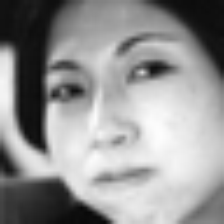

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Epoch 1:   0%|          | 0/50 [00:00<?, ?batch/s]

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Testing [1/50]	overall_loss (2.0331)	Prec@1  (32.8658)	
Epoch: 1   Test Acc: 32.86579513549805

So far best epoch, acc 1 32.86579513549805
Epoch 2; step = 0


Epoch 2:   0%|          | 0/442 [00:00<?, ?batch/s]

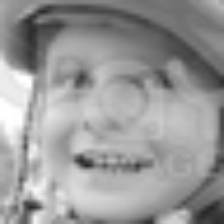

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Epoch 2:   0%|          | 0/50 [00:00<?, ?batch/s]

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Testing [2/50]	overall_loss (1.9935)	Prec@1  (33.1208)	
Epoch: 2   Test Acc: 33.120819091796875

So far best epoch, acc 2 33.120819091796875
Epoch 3; step = 0


Epoch 3:   0%|          | 0/442 [00:00<?, ?batch/s]

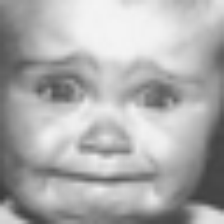

Validation Epoch 3:   0%|          | 0/50 [00:00<?, ?batch/s]

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Testing [3/50]	overall_loss (1.6870)	Prec@1  (56.8059)	
Epoch: 3   Test Acc: 56.80586624145508

So far best epoch, acc 3 56.80586624145508
Epoch 4; step = 0


Epoch 4:   0%|          | 0/442 [00:00<?, ?batch/s]

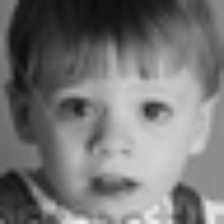

Validation Epoch 4:   0%|          | 0/50 [00:00<?, ?batch/s]


Testing [4/50]	overall_loss (1.4576)	Prec@1  (50.5897)	
Epoch: 4   Test Acc: 50.58973693847656

Epoch 5; step = 0


Epoch 5:   0%|          | 0/442 [00:00<?, ?batch/s]

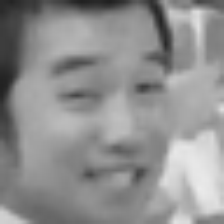

Validation Epoch 5:   0%|          | 0/50 [00:00<?, ?batch/s]


Testing [5/50]	overall_loss (1.2865)	Prec@1  (68.2818)	
Epoch: 5   Test Acc: 68.28179931640625

So far best epoch, acc 5 68.28179931640625
Epoch 6; step = 0


Epoch 6:   0%|          | 0/442 [00:00<?, ?batch/s]

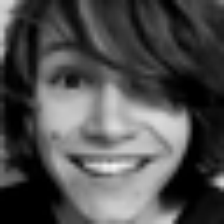

Validation Epoch 6:   0%|          | 0/50 [00:00<?, ?batch/s]


Testing [6/50]	overall_loss (1.2192)	Prec@1  (70.7364)	
Epoch: 6   Test Acc: 70.73637390136719

So far best epoch, acc 6 70.73637390136719
Epoch 7; step = 0


Epoch 7:   0%|          | 0/442 [00:00<?, ?batch/s]

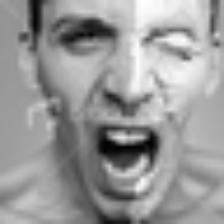

Validation Epoch 7:   0%|          | 0/50 [00:00<?, ?batch/s]


Testing [7/50]	overall_loss (1.1175)	Prec@1  (69.6844)	
Epoch: 7   Test Acc: 69.68441772460938

Epoch 8; step = 0


Epoch 8:   0%|          | 0/442 [00:00<?, ?batch/s]

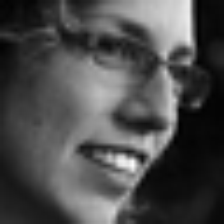

Validation Epoch 8:   0%|          | 0/50 [00:00<?, ?batch/s]


Testing [8/50]	overall_loss (1.0907)	Prec@1  (72.8403)	
Epoch: 8   Test Acc: 72.84029388427734

So far best epoch, acc 8 72.84029388427734
Epoch 9; step = 0


Epoch 9:   0%|          | 0/442 [00:00<?, ?batch/s]

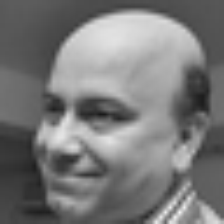

Validation Epoch 9:   0%|          | 0/50 [00:00<?, ?batch/s]


Testing [9/50]	overall_loss (1.2371)	Prec@1  (71.7246)	
Epoch: 9   Test Acc: 71.72457885742188

Epoch 10; step = 1


Epoch 10:   0%|          | 0/442 [00:00<?, ?batch/s]

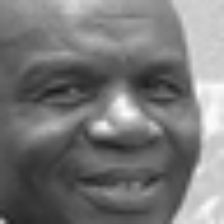

Validation Epoch 10:   0%|          | 0/50 [00:00<?, ?batch/s]


Testing [10/50]	overall_loss (1.1566)	Prec@1  (75.2949)	
Epoch: 10   Test Acc: 75.29486846923828

So far best epoch, acc 10 75.29486846923828
Epoch 11; step = 1


Epoch 11:   0%|          | 0/442 [00:00<?, ?batch/s]

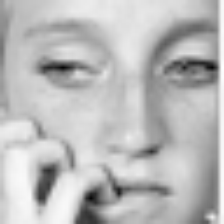

Validation Epoch 11:   0%|          | 0/50 [00:00<?, ?batch/s]


Testing [11/50]	overall_loss (1.3623)	Prec@1  (77.0481)	
Epoch: 11   Test Acc: 77.04814147949219

So far best epoch, acc 11 77.04814147949219
Epoch 12; step = 1


Epoch 12:   0%|          | 0/442 [00:00<?, ?batch/s]

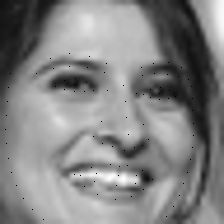

Validation Epoch 12:   0%|          | 0/50 [00:00<?, ?batch/s]


Testing [12/50]	overall_loss (1.3048)	Prec@1  (79.1521)	
Epoch: 12   Test Acc: 79.15206146240234

So far best epoch, acc 12 79.15206146240234
Epoch 13; step = 1


Epoch 13:   0%|          | 0/442 [00:00<?, ?batch/s]

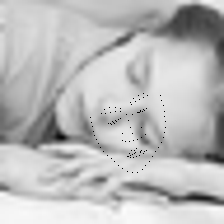

Validation Epoch 13:   0%|          | 0/50 [00:00<?, ?batch/s]


Testing [13/50]	overall_loss (1.1358)	Prec@1  (75.6774)	
Epoch: 13   Test Acc: 75.67739868164062

Epoch 14; step = 1


Epoch 14:   0%|          | 0/442 [00:00<?, ?batch/s]

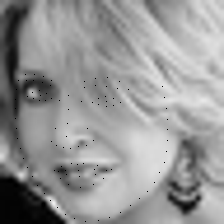

Validation Epoch 14:   0%|          | 0/50 [00:00<?, ?batch/s]


Testing [14/50]	overall_loss (1.6187)	Prec@1  (80.9372)	
Epoch: 14   Test Acc: 80.93720245361328

So far best epoch, acc 14 80.93720245361328
Epoch 15; step = 1


Epoch 15:   0%|          | 0/442 [00:00<?, ?batch/s]

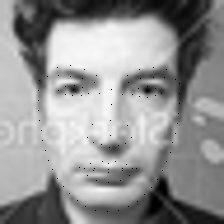

Validation Epoch 15:   0%|          | 0/50 [00:00<?, ?batch/s]


Testing [15/50]	overall_loss (1.6220)	Prec@1  (81.7341)	
Epoch: 15   Test Acc: 81.73414611816406

So far best epoch, acc 15 81.73414611816406
Epoch 16; step = 1


Epoch 16:   0%|          | 0/442 [00:00<?, ?batch/s]

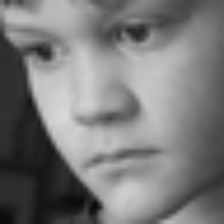

Validation Epoch 16:   0%|          | 0/50 [00:00<?, ?batch/s]


Testing [16/50]	overall_loss (1.7745)	Prec@1  (82.7542)	
Epoch: 16   Test Acc: 82.75422668457031

So far best epoch, acc 16 82.75422668457031
Epoch 17; step = 1


Epoch 17:   0%|          | 0/442 [00:00<?, ?batch/s]

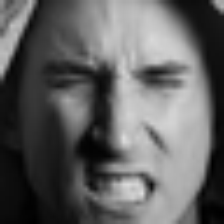

Validation Epoch 17:   0%|          | 0/50 [00:00<?, ?batch/s]


Testing [17/50]	overall_loss (1.7234)	Prec@1  (82.0529)	
Epoch: 17   Test Acc: 82.05291748046875

Epoch 18; step = 2


Epoch 18:   0%|          | 0/442 [00:00<?, ?batch/s]

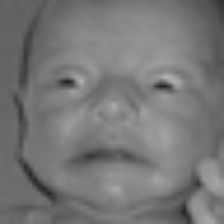

Validation Epoch 18:   0%|          | 0/50 [00:00<?, ?batch/s]


Testing [18/50]	overall_loss (1.7286)	Prec@1  (82.0210)	
Epoch: 18   Test Acc: 82.02104187011719

Epoch 19; step = 2


Epoch 19:   0%|          | 0/442 [00:00<?, ?batch/s]

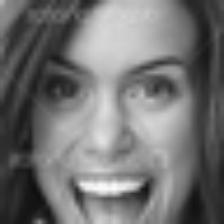

Validation Epoch 19:   0%|          | 0/50 [00:00<?, ?batch/s]


Testing [19/50]	overall_loss (2.0158)	Prec@1  (81.6704)	
Epoch: 19   Test Acc: 81.6703872680664

Epoch 20; step = 2


Epoch 20:   0%|          | 0/442 [00:00<?, ?batch/s]

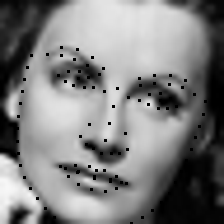

Validation Epoch 20:   0%|          | 0/50 [00:00<?, ?batch/s]


Testing [20/50]	overall_loss (2.0327)	Prec@1  (81.5748)	
Epoch: 20   Test Acc: 81.57475280761719

Epoch 21; step = 2


Epoch 21:   0%|          | 0/442 [00:00<?, ?batch/s]

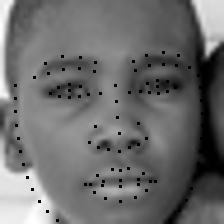

Validation Epoch 21:   0%|          | 0/50 [00:00<?, ?batch/s]


Testing [21/50]	overall_loss (2.2922)	Prec@1  (82.7224)	
Epoch: 21   Test Acc: 82.72235107421875

Epoch 22; step = 2


Epoch 22:   0%|          | 0/442 [00:00<?, ?batch/s]

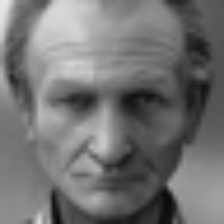

Validation Epoch 22:   0%|          | 0/50 [00:00<?, ?batch/s]


Testing [22/50]	overall_loss (2.3317)	Prec@1  (82.6586)	
Epoch: 22   Test Acc: 82.6585922241211

Epoch 23; step = 2


Epoch 23:   0%|          | 0/442 [00:00<?, ?batch/s]

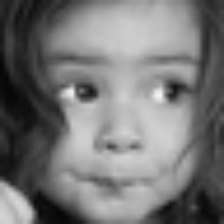

Validation Epoch 23:   0%|          | 0/50 [00:00<?, ?batch/s]


Testing [23/50]	overall_loss (2.4705)	Prec@1  (82.3079)	
Epoch: 23   Test Acc: 82.30793762207031

Epoch 24; step = 2


Epoch 24:   0%|          | 0/442 [00:00<?, ?batch/s]

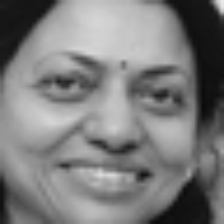

Validation Epoch 24:   0%|          | 0/50 [00:00<?, ?batch/s]


Testing [24/50]	overall_loss (2.5512)	Prec@1  (82.5630)	
Epoch: 24   Test Acc: 82.5629653930664

Epoch 25; step = 2


Epoch 25:   0%|          | 0/442 [00:00<?, ?batch/s]

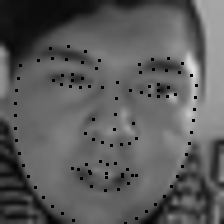

Validation Epoch 25:   0%|          | 0/50 [00:00<?, ?batch/s]


Testing [25/50]	overall_loss (2.4914)	Prec@1  (82.8817)	
Epoch: 25   Test Acc: 82.8817367553711

So far best epoch, acc 25 82.8817367553711
Epoch 26; step = 3


Epoch 26:   0%|          | 0/442 [00:00<?, ?batch/s]

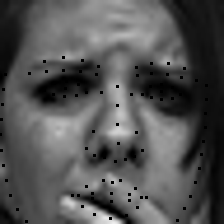

Validation Epoch 26:   0%|          | 0/50 [00:00<?, ?batch/s]


Testing [26/50]	overall_loss (2.5898)	Prec@1  (82.5948)	
Epoch: 26   Test Acc: 82.59484100341797

Epoch 27; step = 3


Epoch 27:   0%|          | 0/442 [00:00<?, ?batch/s]

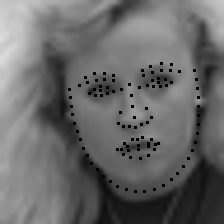

Validation Epoch 27:   0%|          | 0/50 [00:00<?, ?batch/s]


Testing [27/50]	overall_loss (2.6127)	Prec@1  (82.8180)	
Epoch: 27   Test Acc: 82.81798553466797

Epoch 28; step = 3


Epoch 28:   0%|          | 0/442 [00:00<?, ?batch/s]

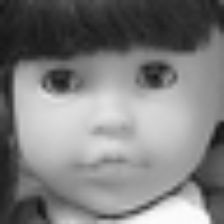

Validation Epoch 28:   0%|          | 0/50 [00:00<?, ?batch/s]


Testing [28/50]	overall_loss (2.6961)	Prec@1  (83.3599)	
Epoch: 28   Test Acc: 83.35990142822266

So far best epoch, acc 28 83.35990142822266
Epoch 29; step = 3


Epoch 29:   0%|          | 0/442 [00:00<?, ?batch/s]

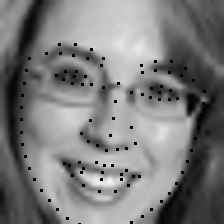

Validation Epoch 29:   0%|          | 0/50 [00:00<?, ?batch/s]


Testing [29/50]	overall_loss (2.7130)	Prec@1  (82.9136)	
Epoch: 29   Test Acc: 82.91361236572266

Epoch 30; step = 3


Epoch 30:   0%|          | 0/442 [00:00<?, ?batch/s]

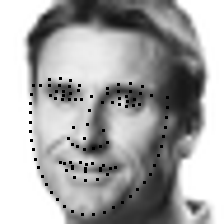

Validation Epoch 31:   0%|          | 0/50 [00:00<?, ?batch/s]


Testing [31/50]	overall_loss (2.7687)	Prec@1  (83.3599)	
Epoch: 31   Test Acc: 83.35990142822266

Epoch 32; step = 3


Epoch 32:   0%|          | 0/442 [00:00<?, ?batch/s]

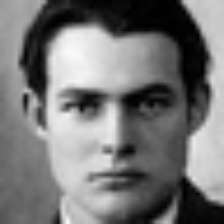

Validation Epoch 32:   0%|          | 0/50 [00:00<?, ?batch/s]


Testing [32/50]	overall_loss (2.8087)	Prec@1  (83.0092)	
Epoch: 32   Test Acc: 83.00924682617188

Epoch 33; step = 3


Epoch 33:   0%|          | 0/442 [00:00<?, ?batch/s]

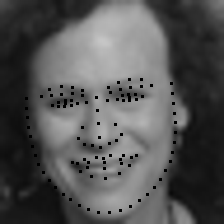

Validation Epoch 33:   0%|          | 0/50 [00:00<?, ?batch/s]


Testing [33/50]	overall_loss (2.8234)	Prec@1  (83.1686)	
Epoch: 33   Test Acc: 83.16863250732422

Epoch 34; step = 4


Epoch 34:   0%|          | 0/442 [00:00<?, ?batch/s]

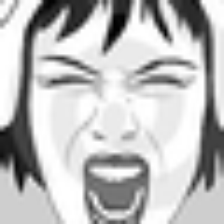

Validation Epoch 34:   0%|          | 0/50 [00:00<?, ?batch/s]


Testing [34/50]	overall_loss (2.5541)	Prec@1  (83.0092)	
Epoch: 34   Test Acc: 83.00924682617188

Epoch 35; step = 4


Epoch 35:   0%|          | 0/442 [00:00<?, ?batch/s]

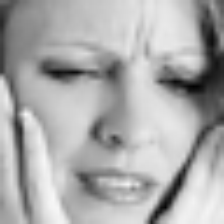

Validation Epoch 36:   0%|          | 0/50 [00:00<?, ?batch/s]


Testing [36/50]	overall_loss (2.3359)	Prec@1  (82.8499)	
Epoch: 36   Test Acc: 82.84986114501953

Epoch 37; step = 4


Epoch 37:   0%|          | 0/442 [00:00<?, ?batch/s]

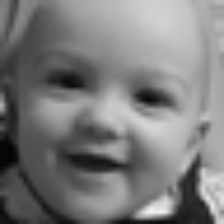

Validation Epoch 37:   0%|          | 0/50 [00:00<?, ?batch/s]


Testing [37/50]	overall_loss (2.2823)	Prec@1  (82.6905)	
Epoch: 37   Test Acc: 82.69047546386719

Epoch 38; step = 4


Epoch 38:   0%|          | 0/442 [00:00<?, ?batch/s]

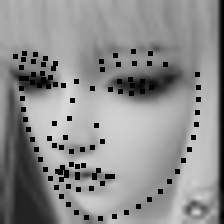

Validation Epoch 38:   0%|          | 0/50 [00:00<?, ?batch/s]


Testing [38/50]	overall_loss (2.2464)	Prec@1  (82.6905)	
Epoch: 38   Test Acc: 82.69047546386719

Epoch 39; step = 4


Epoch 39:   0%|          | 0/442 [00:00<?, ?batch/s]

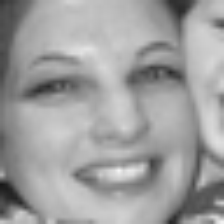

Validation Epoch 39:   0%|          | 0/50 [00:00<?, ?batch/s]


Testing [39/50]	overall_loss (2.2398)	Prec@1  (82.7224)	
Epoch: 39   Test Acc: 82.72235107421875

Epoch 40; step = 4


Epoch 40:   0%|          | 0/442 [00:00<?, ?batch/s]

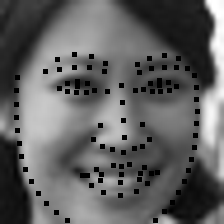

Validation Epoch 40:   0%|          | 0/50 [00:00<?, ?batch/s]


Testing [40/50]	overall_loss (2.2361)	Prec@1  (82.6586)	
Epoch: 40   Test Acc: 82.6585922241211

Epoch 41; step = 4


Epoch 41:   0%|          | 0/442 [00:00<?, ?batch/s]

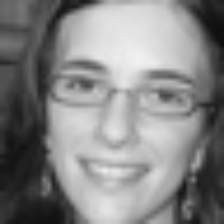


Testing [41/50]	overall_loss (2.2313)	Prec@1  (82.6267)	
Epoch: 41   Test Acc: 82.62671661376953

Epoch 42; step = 5


Epoch 42:   0%|          | 0/442 [00:00<?, ?batch/s]

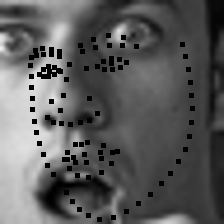

Validation Epoch 42:   0%|          | 0/50 [00:00<?, ?batch/s]


Testing [42/50]	overall_loss (2.2312)	Prec@1  (82.6267)	
Epoch: 42   Test Acc: 82.62671661376953

Epoch 43; step = 5


Epoch 43:   0%|          | 0/442 [00:00<?, ?batch/s]

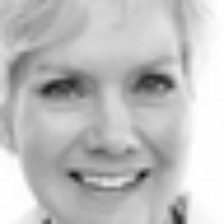

Validation Epoch 43:   0%|          | 0/50 [00:00<?, ?batch/s]


Testing [43/50]	overall_loss (2.2253)	Prec@1  (82.6267)	
Epoch: 43   Test Acc: 82.62671661376953

Epoch 44; step = 5


Epoch 44:   0%|          | 0/442 [00:00<?, ?batch/s]

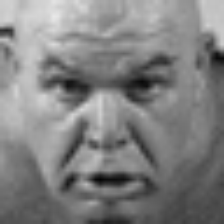

Validation Epoch 44:   0%|          | 0/50 [00:00<?, ?batch/s]


Testing [44/50]	overall_loss (2.2204)	Prec@1  (82.6267)	
Epoch: 44   Test Acc: 82.62671661376953

Epoch 45; step = 5


Epoch 45:   0%|          | 0/442 [00:00<?, ?batch/s]

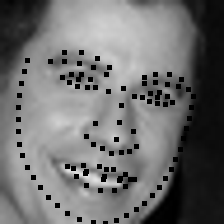

Validation Epoch 45:   0%|          | 0/50 [00:00<?, ?batch/s]


Testing [45/50]	overall_loss (2.2191)	Prec@1  (82.6586)	
Epoch: 45   Test Acc: 82.6585922241211

Epoch 46; step = 5


Epoch 46:   0%|          | 0/442 [00:00<?, ?batch/s]

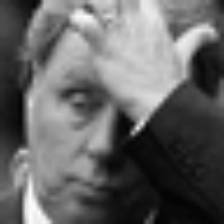

Validation Epoch 46:   0%|          | 0/50 [00:00<?, ?batch/s]


Testing [46/50]	overall_loss (2.2181)	Prec@1  (82.6586)	
Epoch: 46   Test Acc: 82.6585922241211

Epoch 47; step = 5


Epoch 47:   0%|          | 0/442 [00:00<?, ?batch/s]

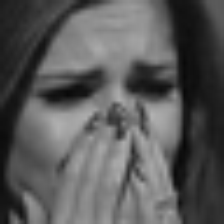

Validation Epoch 47:   0%|          | 0/50 [00:00<?, ?batch/s]


Testing [47/50]	overall_loss (2.2173)	Prec@1  (82.6586)	
Epoch: 47   Test Acc: 82.6585922241211

Epoch 48; step = 5


Epoch 48:   0%|          | 0/442 [00:00<?, ?batch/s]

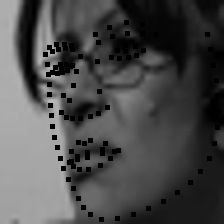

Validation Epoch 48:   0%|          | 0/50 [00:00<?, ?batch/s]


Testing [48/50]	overall_loss (2.2155)	Prec@1  (82.6586)	
Epoch: 48   Test Acc: 82.6585922241211

Epoch 49; step = 5


Epoch 49:   0%|          | 0/442 [00:00<?, ?batch/s]

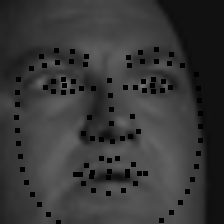

Validation Epoch 49:   0%|          | 0/50 [00:00<?, ?batch/s]


Testing [49/50]	overall_loss (2.2140)	Prec@1  (82.6586)	
Epoch: 49   Test Acc: 82.6585922241211



In [14]:
epochs = 50
best_prec1 = 0.
# run 1: decreasing patch size with AutoAugment
# run 2: increasing patch size with AutoAugment
# run 2.1: rerun of increasing patch size with AutoAugment
# run 2.2: rerun of increasing patch size with AutoAugment, patch size increases by 1 every 10 steps

# run 0.1: no augment
# run 3: only FiFA augment, increasing patch size
# run 4: only FiFA augment, decreasing patch size
# run 5: FiFA_ + AutoAugment, and only AutoAugment

# run 6: noAug till 10, FiFA increase by 1 every 8 steps and randomFLip
# run 7: RandomFlip + FiFA decreasing patch size, step = 8
# run 8: randomFlip only

# run f0: resnet18 on FERplus with only randomflip
# run f1: resnet18 on fer+ with randomflip + FiFA increasing patch size, starts at 10, +1 every 8 steps
# run f2: resnet18 on fer+ with randomflip + FiFA increasing patch size, starts at 15, +1 every 10 steps
# fun f3: resnet18 on fer+ with randomflip + FiFA increasing patch size, starts at 25, +1 every 5 steps
# run f4: resnet18 on fer+ with randomflip + FiFA decreasing patch size, starts at size 5, -1 every 8 steps
run = 'f5'
writer = SummaryWriter(f'run_{run}')
print('\nTraining starting:\n')
for epoch in range(0, epochs):

    # train for one epoch        
    train(train_loader, basemodel,  criterion, optimizer,epochs, epoch, writer, run)
    prec1 = validate(test_loader, basemodel, criterion,  epoch, scheduler, writer, run)
    print("Epoch: {}   Test Acc: {}".format(epoch, prec1))
    print("=================================================================\n")

    # remember best prec@1 and save checkpoint
    is_best = prec1.item() > best_prec1
    best_prec1 = max(prec1.to(device).item(), best_prec1)

    if is_best:
        print('So far best epoch, acc',epoch, best_prec1)
        torch.save(  {
                       'epoch': epoch + 1,
                       'base_state_dict': basemodel.state_dict(),
                       'best_prec1': best_prec1,
                       'optimizer' : optimizer.state_dict(),
                     }, os.path.join('/kaggle/working/trained_model', f'run_{run}_best_checkpoint_rafdb_resnet18_pre_trained_msceleb.pth.tar'))
# writer.close()

# Dataset Preparation for ABAW

In [11]:
def get_analysis_train_dataloader(data_path, label_path, batch_size, num_epochs = 20, epochs = 0):

    dataset_train = RAFDBDataset(choose="train",
        data_path=data_path,
        label_path=label_path,
        app = None,
        transform = None,
        img_size = 224,
        num_epochs = num_epochs,
        epochs = epochs
                                 
    )

    data_loader_train = torch.utils.data.DataLoader(
        dataset_train,
        batch_size=batch_size,
        drop_last=True,
    )
    return data_loader_train, dataset_train.length, dataset_train


def get_analysis_val_dataloader(data_path, label_path, batch_size, num_epochs = 20, epochs = 0):

    dataset_val = RAFDBDataset(choose="test",
        data_path=data_path,
        label_path=label_path,
        app = None,        
        transform = None,
        img_size = 224,
        num_epochs = num_epochs,
        epochs = epochs
    )

    data_loader_val = torch.utils.data.DataLoader(
        dataset_val,
        batch_size=batch_size,
        shuffle=False,
        drop_last=False
    )
    return data_loader_val, dataset_val.length, dataset_val

In [4]:
landmarks_cache = {}

# Open the file and read all lines first to calculate total length for progress bar
with open('/kaggle/input/raf-db-trial/keypoints.txt', 'r') as file:
    lines = file.readlines()

# Iterate over lines with progress bar
for line in tqdm(lines, desc="Processing landmarks", unit="lines"):
    # Split at the first occurrence of the colon
    file_name, coordinates = line.split(":", 1)

    # Remove whitespace around the file name
    file_name = file_name.strip()

    # Convert the string representation of the list of tuples to an actual list of tuples
    coordinates = ast.literal_eval(coordinates.strip())

    # Add to the dictionary
    landmarks_cache[file_name] = coordinates

Processing landmarks:   0%|          | 0/15308 [00:00<?, ?lines/s]

In [5]:
os.listdir('/kaggle/input/')
# /kaggle/input/raf-db-trial/keypoints.txt

['resnet18-checkpoint-real', 'raf-db-trial']

In [6]:
class RandomMasking:
    def __init__(self, mask_size=32, num_masks=5):
        """
        Initialize the masking transformation.
        mask_size: Size of the square mask (in pixels).
        num_masks: Number of random masks to apply.
        """
        self.mask_size = mask_size
        self.num_masks = num_masks

    def __call__(self, img):
        """
        Apply random masks to the image.
        img: Tensor image (C, H, W)
        """
        # Get image dimensions
        _, h, w = img.shape
        
        # Mask the image `num_masks` times
        for _ in range(self.num_masks):
            # Randomly choose top-left corner of the mask
            x = random.randint(0, w - self.mask_size)
            y = random.randint(0, h - self.mask_size)
            
            # Apply the mask (zero out the pixels in the selected region)
            img[:, y:y+self.mask_size, x:x+self.mask_size] = 0
        
        return img

In [7]:
class RAFDBDataset(Dataset):
    def __init__(self, choose, data_path, label_path, app, transform=None, img_size=224, num_epochs = 20, epochs = 0):
        self.image_paths = []
        self.labels = []
        self.data_path = data_path
        self.label_path = label_path
        self.app = app
        self.landmarks_cache = landmarks_cache  # Cache to store landmark coordinates
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.num_epoch = num_epochs
        self.epochs = epochs

        if transform:
            self.transform = transform
        else:
            self.transform = T.Compose([
                T.Resize(256),
                T.CenterCrop(224),
                T.ToTensor(),
                T.Normalize(timm.data.IMAGENET_DEFAULT_MEAN, timm.data.IMAGENET_DEFAULT_STD)
            ])

        self.train = True if choose == "train" else False

        if choose == "train" or choose == "test":
            with open(self.label_path, "r") as f:
                data = f.readlines()

            for i in range(0, len(data)):
                line = data[i].strip('\n').split(" ")

                image_name = line[0]
                sample_temp = image_name.split("_")[0]

                if self.train and sample_temp == "train":
                    image_path = os.path.join(self.data_path, image_name)
                    self.image_paths.append(image_path)
                    self.labels.append(int(line[1]) - 1)

                elif not self.train and sample_temp == "test":
                    image_path = os.path.join(self.data_path, image_name)
                    self.image_paths.append(image_path)
                    self.labels.append(int(line[1]) - 1)
                    
        self.length = len(self.labels)
        self.labels = np.asarray(self.labels)

    def draw_squares_on_landmarks(self, img, landmarks, n):
        dimg = img.copy()
        if n == 0:
            return dimg
        half_n = n // 2
        for kp in landmarks:
            # Ensure coordinates are integers
            top_left = (int(kp[0] - half_n), int(kp[1] - half_n))
            bottom_right = (int(kp[0] + half_n), int(kp[1] + half_n))
            cv2.rectangle(dimg, top_left, bottom_right, (0, 0, 0), -1)  # -1 fills the rectangle
        return dimg

    def get_landmarks(self, img_path):
        if img_path not in self.landmarks_cache:
            return None
            img = cv2.imread(img_path)
            nimg = cv2.resize(img, (224,224))
            k = 100
            padded_image = cv2.copyMakeBorder(
                nimg,
                k,
                k,
                k,
                k,
                cv2.BORDER_CONSTANT,  # Border type
                value=[0, 0, 0]       # Padding color (black in this case)
            )
#             padded_image = padded_image.to(self.device)  # Ensure the image is on the right device
            out = self.app.get(padded_image)
            
            if len(out) == 0:  # Check if any faces were detected
                return None
            
            landmarks = out[0].landmark_2d_106.astype(np.int64)
            self.landmarks_cache[img_path] = landmarks
        return self.landmarks_cache[img_path]

    def augment(self, img_path):
        img = cv2.imread(img_path)
        nimg = cv2.resize(img, (224, 224))
        landmarks = self.get_landmarks(img_path.split('/')[-1])
#         print(landmarks)
        if landmarks is None:  # Skip if no faces are detected
            return nimg, nimg
        
        # Use landmarks to draw squares on the padded image
        aug = self.draw_squares_on_landmarks(nimg, landmarks, n=max(0, self.epochs))
#         plt.imshow(aug)
#         plt.axis('off')  # Optional: turn off axes
#         plt.show()
        return nimg, aug

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img1, img2 = self.augment(img_path)
        
        if self.transform:
            img1 = self.transform(Image.fromarray(img1))
            img2 = self.transform(Image.fromarray(img2))
            
#         img1 = img1.unsqueeze(1)
#         img2 = img2.unsqueeze(1)
        label = torch.tensor(self.labels[idx])
        return img1, img2, label

    def __len__(self):
        return self.length

In [8]:
data_path = '//kaggle/input/raf-db-trial/92_86/92/dataset/RAF'
label_path = '/kaggle/input/raf-db-trial/92_86/92/dataset/list_patition_label.txt'
batch_size = 128

# data_loader_train, train_len, d = get_analysis_val_dataloader(data_path, label_path, batch_size, num_epochs = 20, epochs = 4)

In [13]:
t = d.augment('/kaggle/input/92_86/92/dataset/RAF/train_00016.jpg')

for a,b,c in data_loader_train:
    break

print(a.shape)
print(b.shape)
print(t[1].shape)

torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 224, 224])
(224, 224, 3)


In [17]:
print(a[0].shape)

torch.Size([3, 224, 224])


In [22]:
out = model(a)

In [23]:
out.shape

torch.Size([32, 7])

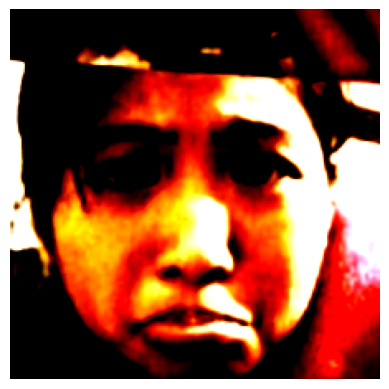

In [28]:
plt.imshow(a[0].permute(1,2,0).numpy()[:, :, ::-1] )
plt.axis('off')  # Optional: turn off axes
plt.show()

In [16]:
t[1].shape

(224, 224, 3)

# Code below is for ABAW, code above is for RAFDB

# Model Training

In [14]:
model = models.resnet50(pretrained=False)
checkpoint = torch.load('/kaggle/input/resnet18-checkpoint-real/res18_naive.pth_MSceleb', map_location=torch.device('cpu'))

state_dict = checkpoint['state_dict'] if 'state_dict' in checkpoint else checkpoint
new_state_dict = {}
for k, v in state_dict.items():
    new_key = k.replace('module.', '')  # Remove 'module.' prefix
    new_state_dict[new_key] = v

# Load the modified state_dict into the model
model.load_state_dict(new_state_dict, strict = False)
# Assuming the checkpoint contains only the state_dict
# model.load_state_dict(checkpoint['state_dict'])

/tmp/ipykernel_37/424955015.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/kaggle/input/resnet18-checkpoint-real/res18_naive.pth_MSceleb', map

RuntimeError: Error(s) in loading state_dict for ResNet:
	size mismatch for layer1.0.conv1.weight: copying a param with shape torch.Size([64, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 64, 1, 1]).
	size mismatch for layer1.1.conv1.weight: copying a param with shape torch.Size([64, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 256, 1, 1]).
	size mismatch for layer2.0.conv1.weight: copying a param with shape torch.Size([128, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 256, 1, 1]).
	size mismatch for layer2.0.downsample.0.weight: copying a param with shape torch.Size([128, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 256, 1, 1]).
	size mismatch for layer2.0.downsample.1.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for layer2.0.downsample.1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for layer2.0.downsample.1.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for layer2.0.downsample.1.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for layer2.1.conv1.weight: copying a param with shape torch.Size([128, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 512, 1, 1]).
	size mismatch for layer3.0.conv1.weight: copying a param with shape torch.Size([256, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 512, 1, 1]).
	size mismatch for layer3.0.downsample.0.weight: copying a param with shape torch.Size([256, 128, 1, 1]) from checkpoint, the shape in current model is torch.Size([1024, 512, 1, 1]).
	size mismatch for layer3.0.downsample.1.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for layer3.0.downsample.1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for layer3.0.downsample.1.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for layer3.0.downsample.1.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for layer3.1.conv1.weight: copying a param with shape torch.Size([256, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 1024, 1, 1]).
	size mismatch for layer4.0.conv1.weight: copying a param with shape torch.Size([512, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 1024, 1, 1]).
	size mismatch for layer4.0.downsample.0.weight: copying a param with shape torch.Size([512, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2048, 1024, 1, 1]).
	size mismatch for layer4.0.downsample.1.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for layer4.0.downsample.1.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for layer4.0.downsample.1.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for layer4.0.downsample.1.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for layer4.1.conv1.weight: copying a param with shape torch.Size([512, 512, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 2048, 1, 1]).
	size mismatch for fc.weight: copying a param with shape torch.Size([87020, 256]) from checkpoint, the shape in current model is torch.Size([1000, 2048]).
	size mismatch for fc.bias: copying a param with shape torch.Size([87020]) from checkpoint, the shape in current model is torch.Size([1000]).

In [12]:
checkpoint['state_dict'].keys()

odict_keys(['module.conv1.weight', 'module.bn1.weight', 'module.bn1.bias', 'module.bn1.running_mean', 'module.bn1.running_var', 'module.layer1.0.conv1.weight', 'module.layer1.0.bn1.weight', 'module.layer1.0.bn1.bias', 'module.layer1.0.bn1.running_mean', 'module.layer1.0.bn1.running_var', 'module.layer1.0.conv2.weight', 'module.layer1.0.bn2.weight', 'module.layer1.0.bn2.bias', 'module.layer1.0.bn2.running_mean', 'module.layer1.0.bn2.running_var', 'module.layer1.1.conv1.weight', 'module.layer1.1.bn1.weight', 'module.layer1.1.bn1.bias', 'module.layer1.1.bn1.running_mean', 'module.layer1.1.bn1.running_var', 'module.layer1.1.conv2.weight', 'module.layer1.1.bn2.weight', 'module.layer1.1.bn2.bias', 'module.layer1.1.bn2.running_mean', 'module.layer1.1.bn2.running_var', 'module.layer2.0.conv1.weight', 'module.layer2.0.bn1.weight', 'module.layer2.0.bn1.bias', 'module.layer2.0.bn1.running_mean', 'module.layer2.0.bn1.running_var', 'module.layer2.0.conv2.weight', 'module.layer2.0.bn2.weight', 'modu

In [8]:
model = models.resnet50(pretrained=True)

# Freeze all the layers except the last few (usually fc and some conv blocks)
for name, param in model.named_parameters():
    if "layer4" not in name and "fc" not in name:  # Only layer4 and fc will be unfrozen
        param.requires_grad = False

# Modify the final fully connected layer for 7 classes
num_classes = 7
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Define a transformation pipeline for the input images
transform = T.Compose([
    T.Resize((224, 224)),  # ResNet input size
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

run = 1
learning_rate = 0.001
# learning_rate = 0.01

# labels_np = np.array(train_labels)
# class_counts = np.bincount(labels_np)          # Generate class counts
# class_weights = 1.0 / class_counts             # Calculate inverse of class counts
# class_weights = class_weights / class_weights.sum()            # Normalize the weights to sum to 1 (optional)
# class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# criterion = LabelSmoothingCrossEntropy()
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)
writer = SummaryWriter(f'run_{run}')

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 207MB/s]


In [9]:
for name, param in model.named_parameters():
    print(name)

conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.0.conv3.weight
layer1.0.bn3.weight
layer1.0.bn3.bias
layer1.0.downsample.0.weight
layer1.0.downsample.1.weight
layer1.0.downsample.1.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer1.1.conv3.weight
layer1.1.bn3.weight
layer1.1.bn3.bias
layer1.2.conv1.weight
layer1.2.bn1.weight
layer1.2.bn1.bias
layer1.2.conv2.weight
layer1.2.bn2.weight
layer1.2.bn2.bias
layer1.2.conv3.weight
layer1.2.bn3.weight
layer1.2.bn3.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.conv3.weight
layer2.0.bn3.weight
layer2.0.bn3.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.we

In [10]:
def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, device, writer, run, num_epochs=20, app=None):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    step = 0
    best_f1 = 0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print("-" * 10)
        flag = True
        if epoch >= 6 and epoch < 20:
            # Increase step after every 3 epochs starting from epoch 6
            step = (epoch - 6) // 3 + 1
            
        data_loader_train, train_len, dataset_train = get_analysis_train_dataloader(data_path, label_path, batch_size, num_epochs = num_epochs, epochs = step)
        data_loader_val, val_len, dataset_val = get_analysis_val_dataloader(data_path, label_path, batch_size, num_epochs = num_epochs, epochs = step)

        dataloaders = {
            "train": data_loader_train,
            "test": data_loader_val
        }

        dataset_sizes = {
            "train": train_len,
            "test": val_len
        }
        
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0.0
            all_preds = []
            all_labels = []
            
            for input1, input2, labels in tqdm(dataloaders[phase]):
                if phase == 'train':
#                     inputs = torch.cat((input1, input2), dim = 0)
#                     labels = torch.cat((labels, labels), dim = 0)
#                     training with no augmentations
                    inputs = input1
#                     if flag:
#                         fig, axes = plt.subplots(1, 2, figsize=(6, 3))
#                         # Display the original image (input1[0]) in the first subplot
#                         axes[0].imshow(input1[0].permute(1, 2, 0).numpy()[:, :, ::-1])  # Assuming input1[0] is in (C, H, W) format
#                         axes[0].set_title('Original')  # Add heading
#                         axes[0].axis('off')  # Turn off the axes
#                         # Display the augmented image (input2[0]) in the second subplot
#                         axes[1].imshow(input2[0].permute(1, 2, 0).numpy()[:, :, ::-1])  # Assuming input2[0] is in (C, H, W) format
#                         axes[1].set_title('Augmented')  # Add heading
#                         axes[1].axis('off')  # Turn off the axes
#                         # Show the figure with both images
#                         plt.tight_layout()
#                         plt.show()
# #                         plt.imshow(input2[0].permute(1,2,3,0).squeeze(0))
# #                         plt.axis('off')  # Optional: turn off axes
# #                         plt.show()
#                         flag = False
                else:
                    inputs = input1
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
            
#             if phase == 'train' and (epoch+1) % 5 == 0:
#                 scheduler.step()
#                 torch.save(model.state_dict(), f'/kaggle/working/trained_model/phase6_freezing_epoch_{epoch}.pth')
            epoch_loss = running_loss / (dataset_sizes[phase] * (1 if phase == 'train' else 1))
            epoch_acc = running_corrects.double() / (dataset_sizes[phase] * (1 if phase == 'train' else 1))
            # Calculate F1 score, precision, and recall
            epoch_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
            epoch_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
            epoch_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
            
            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1: {epoch_f1:.4f} Precision: {epoch_precision:.4f} Recall: {epoch_recall:.4f}")
            
            # Log the metrics
            writer.add_scalar(f'{phase}{run}/Loss', epoch_loss, epoch)
            writer.add_scalar(f'{phase}{run}/Accuracy', epoch_acc, epoch)
            writer.add_scalar(f'{phase}{run}/F1', epoch_f1, epoch)
            writer.add_scalar(f'{phase}{run}/Precision', epoch_precision, epoch)
            writer.add_scalar(f'{phase}{run}/Recall', epoch_recall, epoch)
            
            # Log the learning rate as a scalar
            current_lr = optimizer.param_groups[0]['lr']
            writer.add_scalar(f'{phase}{run}/Learning_Rate', current_lr, epoch)
            
            if phase == 'test' and epoch_f1 > best_f1:
                best_f1 = epoch_f1
                torch.save(model.state_dict(), f'/kaggle/working/trained_model/phase_{run}_best.pth')  # Save the model

        
        print()
        exp_lr_scheduler.step()
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

#     torch.save(model.state_dict(), f'/kaggle/working/trained_model/phase{run}freezing_final_epoch_{num_epochs}.pth')  # Save the model
#     best_model_wts = copy.deepcopy(model.state_dict())
#     model.load_state_dict(best_model_wts)
    return model

In [11]:
# Increase the message rate limit for printing training progress
from notebook.services.config import ConfigManager
cm = ConfigManager().update('notebook', {
    "NotebookApp": {
        "iopub_msg_rate_limit": 10000,  # Increase to 10000 messages/sec
        "rate_limit_window": 10.0,      # Increase the rate limit window to 10 seconds
    }
})

Epoch 0/29
----------


  0%|          | 0/95 [00:00<?, ?it/s]

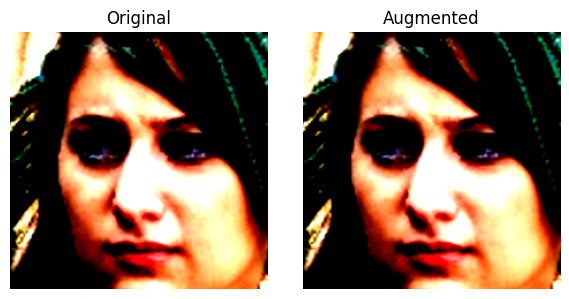

train Loss: 1.1699 Acc: 0.6608 F1: 0.6655 Precision: 0.6831 Recall: 0.6669


  0%|          | 0/24 [00:00<?, ?it/s]

test Loss: 15.4987 Acc: 0.2216 F1: 0.0804 Precision: 0.0491 Recall: 0.2216

Epoch 1/29
----------


  0%|          | 0/95 [00:00<?, ?it/s]

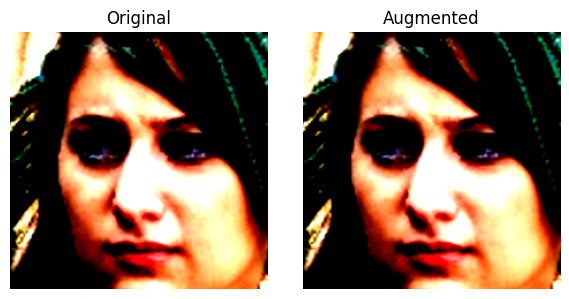

train Loss: 2.2667 Acc: 0.2759 F1: 0.2055 Precision: 0.2304 Recall: 0.2785


  0%|          | 0/24 [00:00<?, ?it/s]

test Loss: 1.7243 Acc: 0.3765 F1: 0.2310 Precision: 0.1802 Recall: 0.3765

Epoch 2/29
----------


  0%|          | 0/95 [00:00<?, ?it/s]

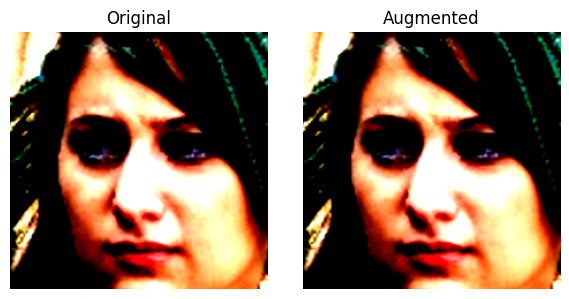

train Loss: 1.6517 Acc: 0.4068 F1: 0.3085 Precision: 0.3571 Recall: 0.4105


  0%|          | 0/24 [00:00<?, ?it/s]

test Loss: 1.6889 Acc: 0.2627 F1: 0.1737 Precision: 0.2999 Recall: 0.2627

Epoch 3/29
----------


  0%|          | 0/95 [00:00<?, ?it/s]

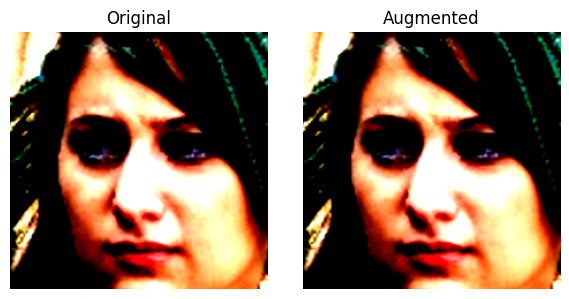

train Loss: 1.4136 Acc: 0.5115 F1: 0.4710 Precision: 0.4923 Recall: 0.5162


  0%|          | 0/24 [00:00<?, ?it/s]

test Loss: 2.3739 Acc: 0.2216 F1: 0.0804 Precision: 0.0491 Recall: 0.2216

Epoch 4/29
----------


  0%|          | 0/95 [00:00<?, ?it/s]

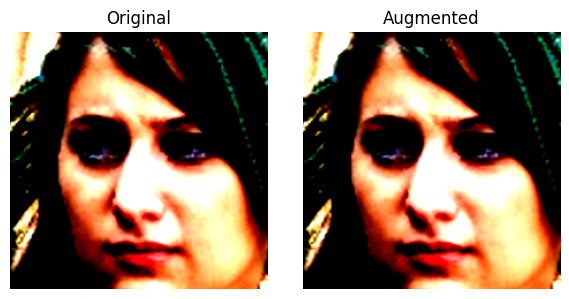

train Loss: 1.4875 Acc: 0.4392 F1: 0.4115 Precision: 0.4084 Recall: 0.4433


  0%|          | 0/24 [00:00<?, ?it/s]

test Loss: 1.9312 Acc: 0.2223 F1: 0.0818 Precision: 0.4354 Recall: 0.2223

Epoch 5/29
----------


  0%|          | 0/95 [00:00<?, ?it/s]

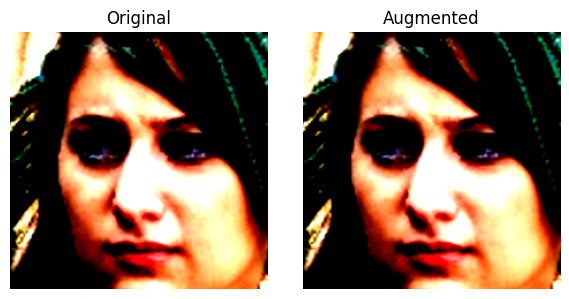

train Loss: 1.1419 Acc: 0.6015 F1: 0.5837 Precision: 0.5771 Recall: 0.6070


  0%|          | 0/24 [00:00<?, ?it/s]

test Loss: 4.1967 Acc: 0.2216 F1: 0.0804 Precision: 0.0491 Recall: 0.2216

Epoch 6/29
----------


  0%|          | 0/95 [00:00<?, ?it/s]

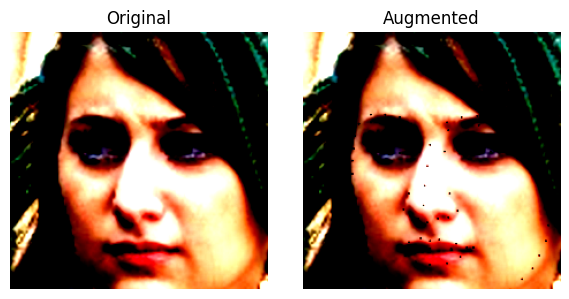

train Loss: 1.2809 Acc: 0.6125 F1: 0.5845 Precision: 0.5720 Recall: 0.6181


  0%|          | 0/24 [00:00<?, ?it/s]

test Loss: 3.2689 Acc: 0.2216 F1: 0.0804 Precision: 0.0491 Recall: 0.2216

Epoch 7/29
----------


  0%|          | 0/95 [00:00<?, ?it/s]

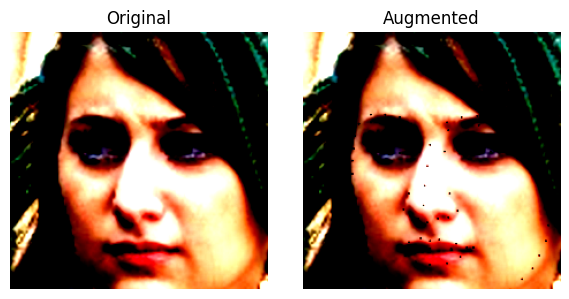

train Loss: 1.2562 Acc: 0.5933 F1: 0.5624 Precision: 0.5478 Recall: 0.5987


  0%|          | 0/24 [00:00<?, ?it/s]

test Loss: 2.2068 Acc: 0.2269 F1: 0.0923 Precision: 0.4652 Recall: 0.2269

Epoch 8/29
----------


  0%|          | 0/95 [00:00<?, ?it/s]

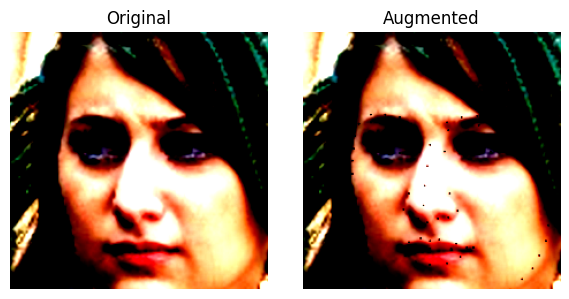

train Loss: 0.8030 Acc: 0.7153 F1: 0.7179 Precision: 0.7235 Recall: 0.7219


  0%|          | 0/24 [00:00<?, ?it/s]

test Loss: 15.7361 Acc: 0.2216 F1: 0.0804 Precision: 0.0491 Recall: 0.2216

Epoch 9/29
----------


  0%|          | 0/95 [00:00<?, ?it/s]

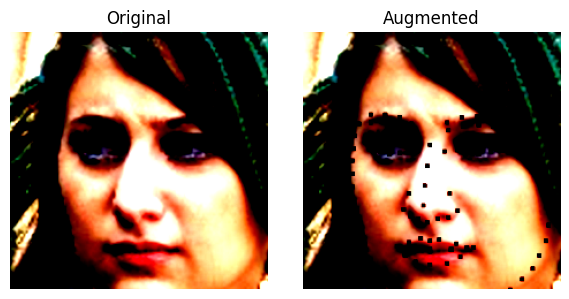

train Loss: 1.1924 Acc: 0.6778 F1: 0.6515 Precision: 0.6291 Recall: 0.6840


  0%|          | 0/24 [00:00<?, ?it/s]

test Loss: 7.1206 Acc: 0.2220 F1: 0.0811 Precision: 0.4354 Recall: 0.2220

Epoch 10/29
----------


  0%|          | 0/95 [00:00<?, ?it/s]

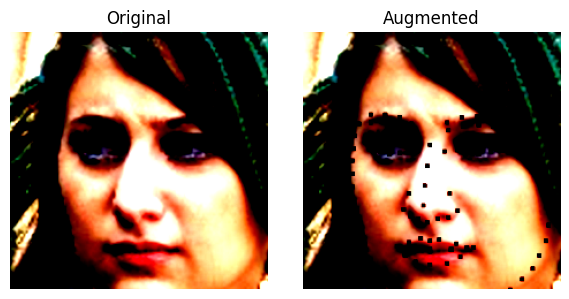

train Loss: 1.0786 Acc: 0.6616 F1: 0.6311 Precision: 0.6066 Recall: 0.6676


  0%|          | 0/24 [00:00<?, ?it/s]

test Loss: 2.1643 Acc: 0.2686 F1: 0.1718 Precision: 0.5972 Recall: 0.2686

Epoch 11/29
----------


  0%|          | 0/95 [00:00<?, ?it/s]

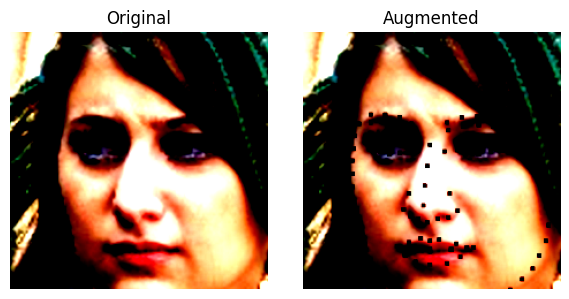

KeyboardInterrupt: 

In [12]:
num_epochs = 30

description = (
    f"Training parameters for RAFDB on Resnet50:\n"
    f"Model: {model.__class__.__name__}\n"
    f"Criterion: {criterion.__class__.__name__}\n"
    f"Optimizer: {optimizer.__class__.__name__}\n"
    f"Scheduler: {exp_lr_scheduler.__class__.__name__}\n"
    f"Device: {device}\n"
    f"Number of epochs: {num_epochs}\n"
    f"Batch Size: {batch_size}\n"
#     f"Stride: {stride}\n"
#     f"Sequence Length: {sequence_length}"
)
writer.add_text(f"Desc_{run}/Training Parameters", description, global_step=0)
model_ft = train_model(model,criterion, optimizer, exp_lr_scheduler, dataloaders = None, dataset_sizes = None, device = device, writer = writer, run = run, num_epochs=num_epochs)

In [ ]:
num_epochs = 30

train_loader, train_len, dataset_train = get_analysis_train_dataloader(data_path, label_path, batch_size, num_epochs = num_epochs, epochs = 0)
val_loader, val_len, dataset_val = get_analysis_val_dataloader(data_path, label_path, batch_size, num_epochs = num_epochs, epochs = 0)


# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
writer = SummaryWriter(log_dir='experiment_1')
num_epochs = 20


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    # Initialize tqdm progress bar for training loop
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] - Training", unit="batch")
    
    # Track metrics for training
    all_train_preds = []
    all_train_labels = []
    
    for inputs1, inputs2, labels in train_loader_tqdm:
        inputs = inputs1
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Store predictions and labels
        _, predicted = torch.max(outputs.data, 1)
        all_train_preds.extend(predicted.cpu().numpy())
        all_train_labels.extend(labels.cpu().numpy())

        # Update tqdm description
        train_loader_tqdm.set_postfix(loss=f"{running_loss / len(train_loader):.4f}")

    # Calculate training metrics
    train_accuracy = 100 * sum(np.array(all_train_preds) == np.array(all_train_labels)) / len(all_train_labels)
    train_precision = precision_score(all_train_labels, all_train_preds, average='macro')
    train_recall = recall_score(all_train_labels, all_train_preds, average='macro')
    train_f1 = f1_score(all_train_labels, all_train_preds, average='macro')

    # Log training metrics
    writer.add_scalar('Loss/train', running_loss/len(train_loader), epoch)
    writer.add_scalar('Accuracy/train', train_accuracy, epoch)
    writer.add_scalar('Precision/train', train_precision, epoch)
    writer.add_scalar('Recall/train', train_recall, epoch)
    writer.add_scalar('F1 Score/train', train_f1, epoch)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {train_accuracy:.2f}%")

    # Validation phase
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    # Initialize tqdm progress bar for validation loop
    val_loader_tqdm = tqdm(val_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] - Validation", unit="batch")
    
    with torch.no_grad():
        for inputs1, inputs2, labels in val_loader_tqdm:
            inputs = inputs1
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Collect all predictions and labels for metric calculation
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate validation metrics
    val_accuracy = 100 * correct / total
    val_precision = precision_score(all_labels, all_preds, average='macro')
    val_recall = recall_score(all_labels, all_preds, average='macro')
    val_f1 = f1_score(all_labels, all_preds, average='macro')
#     current_lr = exp_lr_scheduler.get_last_lr()

    # Log validation metrics
    writer.add_scalar('Loss/val', running_loss/len(train_loader), epoch)
    writer.add_scalar('Accuracy/val', val_accuracy, epoch)
    writer.add_scalar('Precision/val', val_precision, epoch)
    writer.add_scalar('Recall/val', val_recall, epoch)
    writer.add_scalar('F1 Score/val', val_f1, epoch)

    print(f"Validation Accuracy: {val_accuracy:.2f}%")
    print(f"Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1:.4f}")

# Close the SummaryWriter after training is done
writer.close()


Epoch [1/20] - Training:   0%|          | 0/95 [00:00<?, ?batch/s]

In [39]:
 torch.save(model.state_dict(), f'/kaggle/working/trained_model/rafDB_Fiducial_14_epochs.pth')

In [89]:
inputs = torch.cat((a, b), dim = 0)
labels = torch.cat((c, c), dim = 0)

inputs.shape

torch.Size([32, 3, 1, 224, 224])

In [70]:

a.unsqueeze(0).shape

torch.Size([1, 16, 3, 224, 224])

In [90]:
x = inputs.to(device)
t = model(x)

In [91]:
t.shape

torch.Size([32, 7])

# Independent Validation

In [15]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [ ]:
val_seqs, val_labels = sequence_extractor(
    data_dict = data_builder(val_label_path, train = False),
    data_path = data_path,
    min_stride = 1,
    sequence_length = 5,
    train = False
)

val_dataset = ABAWFeatureDataset(val_seqs, val_labels, transform = T.Compose([
        T.Resize(256),
        T.CenterCrop(224),
        T.ToTensor(),
        T.Normalize(timm.data.IMAGENET_DEFAULT_MEAN, timm.data.IMAGENET_DEFAULT_STD)
    ])
)

data_loader_val = DataLoader(val_dataset, batch_size=batch_size, shuffle = True)


In [ ]:
running_loss = 0.0
running_corrects = 0.0
all_preds = []
all_labels = []
            
    
for inputs, labels in tqdm(data_loader_val):
    inputs = inputs.to(device)
    labels = labels.to(device)

#     optimizer.zero_grad()

    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)

    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

epoch_loss = running_loss / dataset_sizes['val']
epoch_acc = running_corrects.double() / dataset_sizes['val']

# Calculate F1 score, precision, and recall
epoch_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
epoch_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
epoch_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)

print(f"{'val'} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1: {epoch_f1:.4f} Precision: {epoch_precision:.4f} Recall: {epoch_recall:.4f}")
            

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Example list of image paths
data_path = '/kaggle/input/abaw-7-dataset/cropped_aligned'
image_paths = [os.path.join(data_path, x) for x in train_seqs[0]]
labels = [train_labels[0] for x in train_seqs[0]]
# Number of images
n_images = len(image_paths)

# Calculate grid size (assuming a square grid)
grid_size = int(n_images**0.5) + (n_images**0.5 != int(n_images**0.5))

# Create a figure with a grid of subplots
fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over images and plot them with labels
for i, (image_path, label) in enumerate(zip(image_paths, labels)):
    img = mpimg.imread(image_path)
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide axes
    axes[i].set_title(label, fontsize=12)  # Add label

# Hide any remaining empty subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# Testing Facial Landmark detector on cuda

In [11]:
# app = FaceAnalysis(providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
# app.prepare(ctx_id=0, det_size=(640, 640))  # Set detection size, though not used directly for cropped images

# Example usage
cropped_face_path = '/kaggle/input/raf-db-trial/92_86/92/dataset/RAF/test_0001.jpg'
cropped_face = cv2.imread(cropped_face_path)
top = 100
bottom = 100
left = 100
right = 100

# Pad the image
padded_image = cv2.copyMakeBorder(
    cropped_face,
    top,
    bottom,
    left,
    right,
    cv2.BORDER_CONSTANT,  # Border type
    value=[0, 0, 0]       # Padding color (black in this case)
)
# cv2_imshow(padded_image)
for i in range(10):
    out = app.get(padded_image)

Build a dynamic FER model which takes video 